<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/FullandFinalformetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [140]:

data_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database'




 **Create directories for training and validation data**

In [148]:
train_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_train'
validation_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

##  Create class subdirectories in training and validation directories

In [149]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Create class subdirectories in training and validation directories
class_names = ['Tuberculosis', 'Normal']  # Adjust class names accordingly
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

In [151]:
class_names = ['Tuberculosis', 'Normal']
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


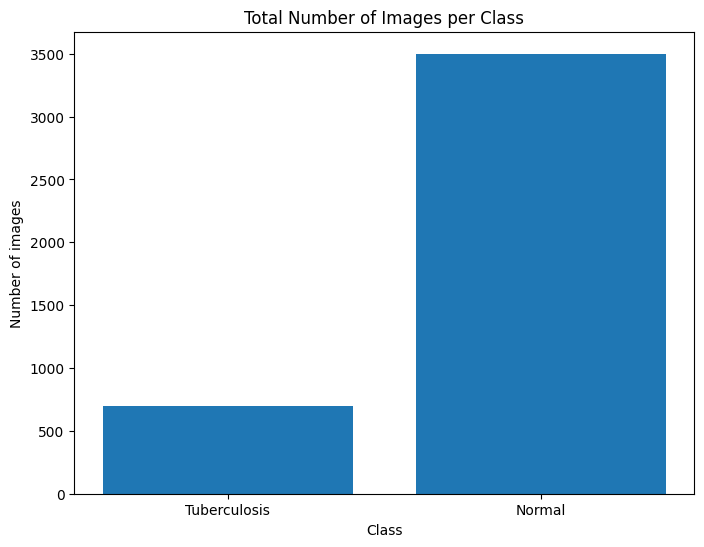

In [152]:
# Convert labels to numeric format
label_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
labels = np.array([label_dict[label] for label in labels])

# Plot total number of images per class
def plot_distribution(data, title):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, [np.sum(data == label_dict[class_name]) for class_name in class_names])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

# Plot initial distribution of images
plot_distribution(labels, 'Total Number of Images per Class')

## Split data into training and validation sets

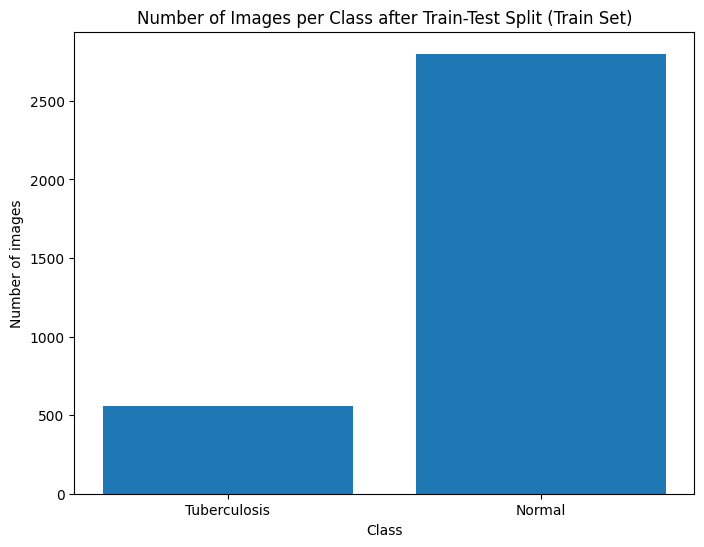

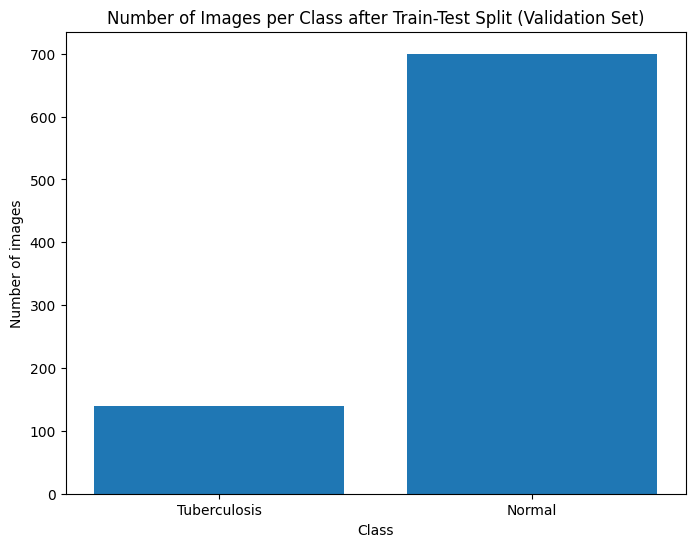

In [153]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Plot distribution of images after train-test split
plot_distribution(train_labels, 'Number of Images per Class after Train-Test Split (Train Set)')
plot_distribution(val_labels, 'Number of Images per Class after Train-Test Split (Validation Set)')


# Apply random undersampling to balance the classes in the training set

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


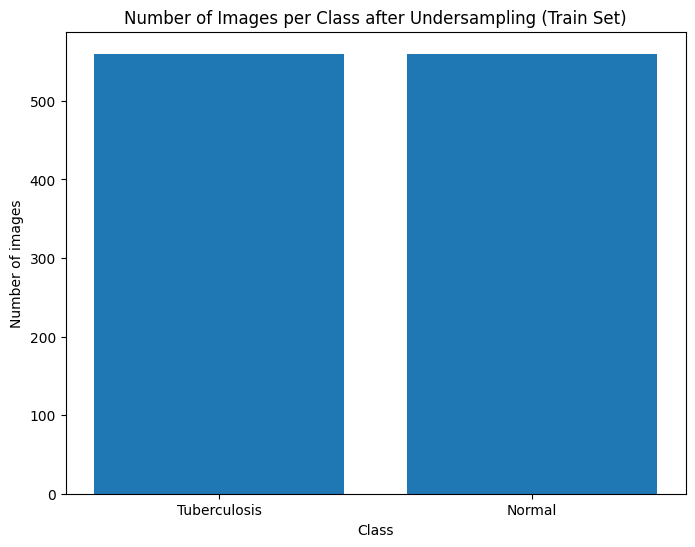

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


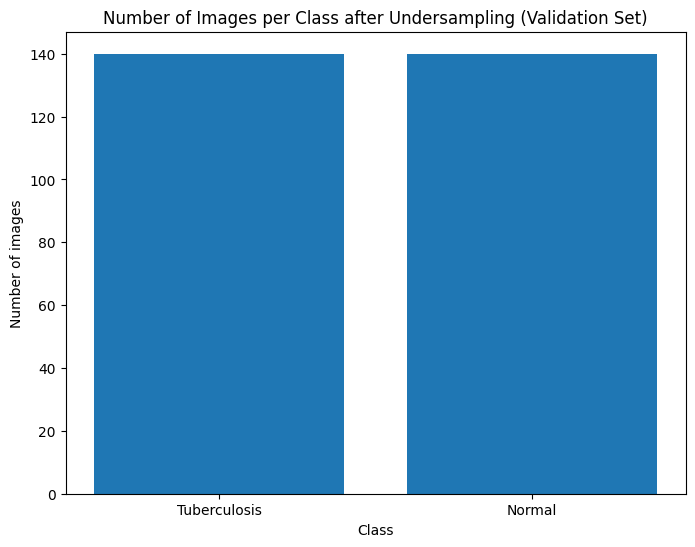

In [154]:
# Plot distribution of images after undersampling
rus = RandomUnderSampler()
train_paths, train_labels = rus.fit_resample(np.array(train_paths).reshape(-1, 1), train_labels)
train_paths = train_paths.flatten()
plot_distribution(train_labels, 'Number of Images per Class after Undersampling (Train Set)')
# Apply random undersampling to balance the classes in the validation set
val_paths, val_labels = rus.fit_resample(np.array(val_paths).reshape(-1, 1), val_labels)
val_paths = val_paths.flatten()
plot_distribution(val_labels, 'Number of Images per Class after Undersampling (Validation Set)')




In [155]:
# Copy images to respective directories and count them
def copy_images(image_paths, labels, target_dir):
    count = {class_name: 0 for class_name in class_names}
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        target_class_dir = os.path.join(target_dir, class_name)
        shutil.copy(img_path, target_class_dir)
        count[class_name] += 1
    return count

train_count = copy_images(train_paths, train_labels, train_dir)
val_count = copy_images(val_paths, val_labels, validation_dir)

print("Number of images copied for training after undersampling:")
print(train_count)

print("Number of images copied for validation after undersampling:")
print(val_count)





Number of images copied for training after undersampling:
{'Tuberculosis': 560, 'Normal': 560}
Number of images copied for validation after undersampling:
{'Tuberculosis': 140, 'Normal': 140}


## transfer learning with dense121

In [174]:
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(224, 224, 3))

# Add custom layers on top of the base model for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (1 output unit with sigmoid activation)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_16         │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_16[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_17         │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_17[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [175]:
# Prepare data generators for training and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing the training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = True)  # Binary classification

validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # Directory containing the validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

Found 1693 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


## training

In [176]:
 model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Reduce steps per epoch
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Reduce validation steps
    epochs=1,  # Keep it low

)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 414s 8s/step - accuracy: 0.7758 - loss: 0.4352 - val_accuracy: 0.9531 - val_loss: 0.1309


## Evaluating the model

9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step
              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95       140
Tuberculosis       0.98      0.91      0.95       140

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



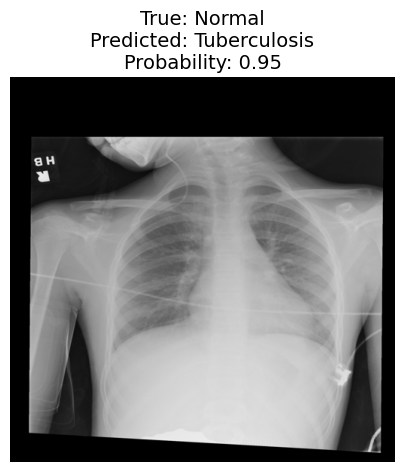

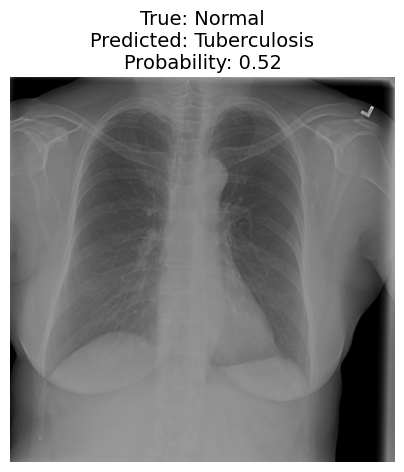

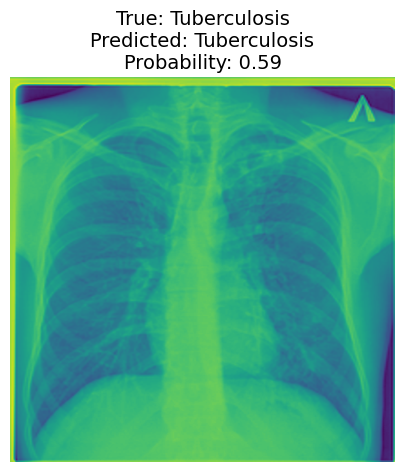

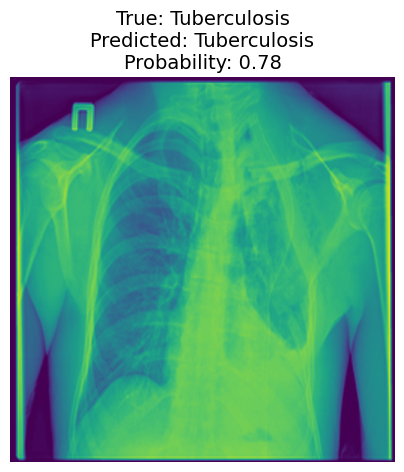

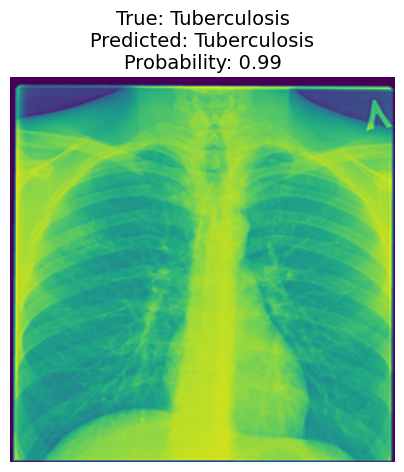

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the label names corresponding to the model's output classes
LABELS = ["Normal", "Tuberculosis"]

# Predict the classes for the validation set
val_preds = model.predict(validation_generator)
val_preds_class = (val_preds > 0.5).astype(int)  # Convert probabilities to binary classes

# Get the true labels and image file paths
val_true_labels = validation_generator.classes
val_image_paths = validation_generator.filepaths  # File paths for validation images

# Print classification report
print(classification_report(val_true_labels, val_preds_class, target_names=LABELS))

# Display only images classified as Tuberculosis
def display_tuberculosis_predictions(num_images=5):
    count = 0  # Counter for images displayed

    for i in range(len(val_preds_class)):
        if val_preds_class[i][0] == 1:  # Check if classified as Tuberculosis
            img_path = val_image_paths[i]
            true_label = LABELS[val_true_labels[i]]
            predicted_label = LABELS[val_preds_class[i][0]]
            prediction_value = val_preds[i][0]

            # Load and preprocess the image for display
            img = plt.imread(img_path)

            # Plot the image with true and predicted labels, and prediction value
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('Off')
            plt.title(f"True: {true_label}\nPredicted: {predicted_label}\nProbability: {prediction_value:.2f}", fontsize=14)
            plt.show()

            count += 1
            if count == num_images:  # Stop after displaying the specified number of images
                break

# Show predictions for images classified as Tuberculosis
display_tuberculosis_predictions(num_images=5)





In [185]:
# Classification Report
true_classes = validation_generator.classes
print("Classification Report:")
print(classification_report(true_classes, val_preds_class))
true_classes = true_classes[:len(val_preds_class)]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       140
           1       0.98      0.91      0.95       140

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



## Accuracy plotting

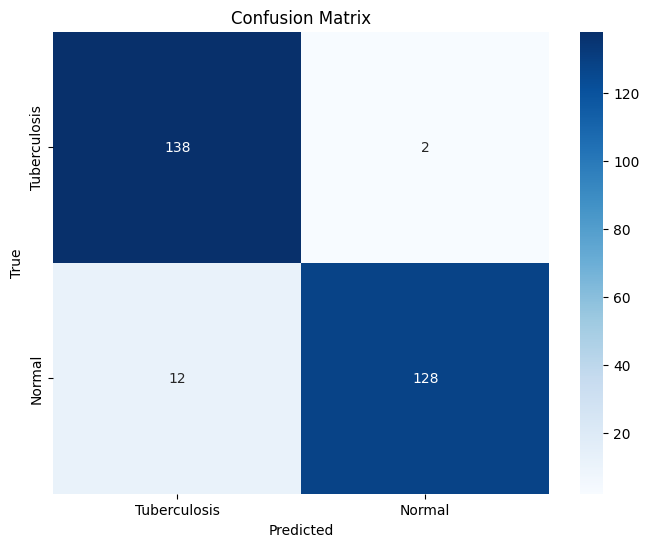

In [186]:
import seaborn as sns
# Compute the classification report
val_labels_true = validation_generator.classes
# Plot confusion matrix
conf_matrix = confusion_matrix(val_labels_true, val_preds_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step


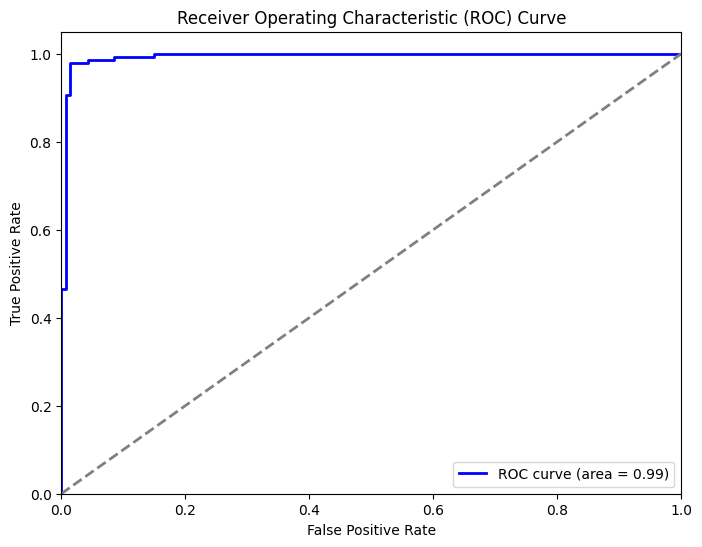

In [180]:
# Plot AUC-ROC curve
val_preds_prob = model.predict(validation_generator)
fpr, tpr, _ = roc_curve(val_labels_true, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


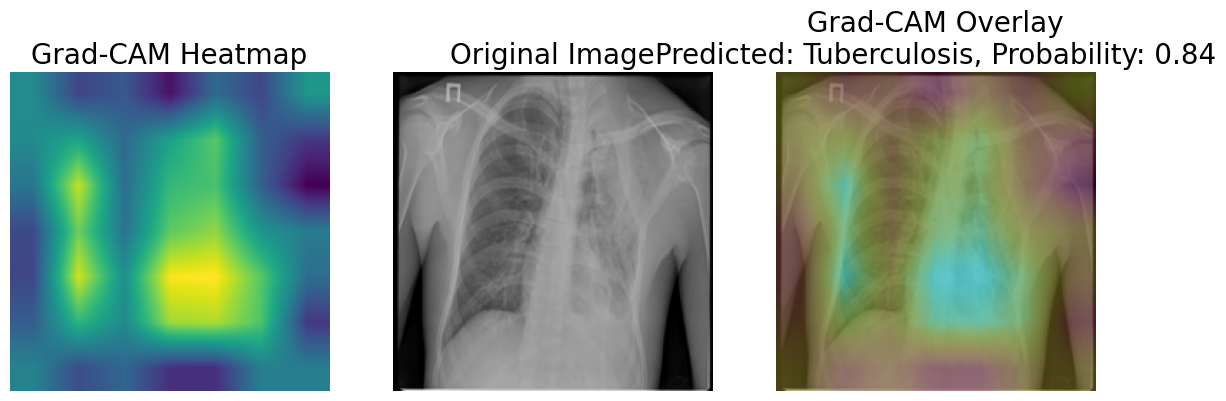

In [205]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If no layer is specified, attempt to find the last 4D layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Loop over layers in reverse order to find the last convolutional layer
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find a 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Create a gradient model to extract activations and predictions
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output],
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]

        # Compute gradients of the loss with respect to the convolutional outputs
        grads = tape.gradient(loss, convOutputs)

        # Guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # Average weights of the gradients
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs[0]), axis=-1)

        # Resize heatmap to match input image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # Apply color map and overlay heatmap on the original image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)


# Function to process a single image
def process_single_image(img_path, model, target_layer):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image at path: {img_path}")

    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    original_img = cv2.resize(original_img, (224, 224))  # Resize to match heatmap dimensions
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the class and probability
    preds = model.predict(img_array)
    predicted_prob = preds[0][0]  # For binary classification, this gives the probability of the positive class (e.g., Tuberculosis)

    # Default threshold (can be customized)
    threshold = 0.5

    # Determine predicted class based on the probability
    predicted_label = "Tuberculosis" if predicted_prob >= threshold else "Normal"

    # Compute Grad-CAM
    cam = GradCAM(model, classIdx=0, layerName=target_layer)
    heatmap = cam.compute_heatmap(img_array)

    # Overlay heatmap on the original image
    heatmap_resized, overlay = cam.overlay_heatmap(heatmap, original_img)

    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(14, 14))
    ax[0].imshow(heatmap, cmap="viridis")
    ax[0].axis("Off")
    ax[0].set_title("Grad-CAM Heatmap", fontsize=20)

    ax[1].imshow(original_img)
    ax[1].axis("Off")
    ax[1].set_title("Original Image", fontsize=20)

    ax[2].imshow(overlay)
    ax[2].axis("Off")
    ax[2].set_title(f"Grad-CAM Overlay\nPredicted: {predicted_label}, Probability: {predicted_prob:.2f}", fontsize=20)

    plt.show()

# Specify the target convolutional layer and image path
target_layer = "conv5_block16_1_conv"  # Replace with the appropriate layer for your model
img_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database_train/Tuberculosis/Tuberculosis-109.png"  # Replace with the full path to your image

# Process and display Grad-CAM for the image
process_single_image(img_path, model, target_layer)